# 概要

遺伝子でない特徴量と遺伝子特徴量を組み合わせてEDAを行う

In [1]:
import os
import random
import itertools
import re
import math
import collections

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY

import functions

functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
# check(df_clinical)

In [4]:
df_clinical.shape

(2509, 36)

## カラムの順序変更（読みやすさのため）

In [5]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [6]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

In [7]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [8]:
# save
functions.make_dir(config.INTERIM_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_EDA_DIR + "/df_MTST.pkl")

## 臨床データの読み込み

In [9]:
df_clinical = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_clinical.pkl")
df_MB = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")
df_MTST = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_MTST.pkl")

df_MB.set_index("PATIENT_ID", inplace=True)

## 遺伝子データの読み込み

In [10]:
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


dict_gene_expressions = dict(
    {
        "mrna_agilent_microarray": df_mrna_agilent_microarray,
        "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
        "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    }
)
dict_genes = {
    "cna": df_cna,
    "methylation_promoters_rrbs": df_methylation_promoters_rrbs,
    "mrna_agilent_microarray_zscores_ref_all_samples": df_mrna_agilent_microarray_zscores_ref_all_samples,
    "mrna_agilent_microarray_zscores_ref_diploid_samples": df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    "mrna_agilent_microarray": df_mrna_agilent_microarray,
}

# 臨床データのEDA

## 各特徴毎の再発期間の確認

サブグループ毎に再発した患者の割合・晩年再発・カプランマイヤー曲線を確認する

In [11]:
functions.check(df_MB)

,feature,dtypes,nan,count,max,min,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,76,1909,45.000000,0.000000,31,,
1,NPI,float64,1,1984,6.680000,1.000000,323,,
2,CELLULARITY,object,68,1917,nan,nan,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
3,COHORT,float64,0,1985,5.000000,1.000000,5,[1. 2. 3. 5. 4.],"{3.0: 763, 1.0: 526, 2.0: 288, 4.0: 238, 5.0: 170}"
4,INFERRED_MENOPAUSAL_STATE,object,5,1980,nan,nan,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
5,SEX,object,0,1985,nan,nan,1,['Female'],{'Female': 1985}
6,INTCLUST,object,5,1980,nan,nan,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
7,AGE_AT_DIAGNOSIS,float64,0,1985,96.290000,21.930000,1624,,
8,CLAUDIN_SUBTYPE,object,5,1980,nan,nan,7,['claudin-low' 'LumA' 'LumB' 'Normal' nan 'Her2' 'Basal' 'NC'],"{'LumA': 700, 'LumB': 475, 'Her2': 224, 'claudin-low': 218, 'Basal': 209, 'Normal': 148, 'NC': 6}"
9,THREEGENE,object,221,1764,nan,nan,4,['ER-/HER2-' 'ER+/HER2- High Prolif' nan 'ER+/HER2- Low Prolif' 'HER2+'],"{'ER+/HER2- Low Prolif': 640, 'ER+/HER2- High Prolif': 617, 'ER-/HER2-': 309, 'HER2+': 198}"


In [12]:
df_MB.dropna(subset="RFS_STATUS", inplace=True)

### recurrence patient num

In [13]:
df_MB.RFS_STATUS.value_counts()

0:Not Recurred    1180
1:Recurred         804
Name: RFS_STATUS, dtype: int64

In [17]:
df_MB[df_MB["RFS_STATUS"] == "1:Recurred"].groupby("CLAUDIN_SUBTYPE").count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,88,93,92,93,93,93,93,93,74,82,91,93,93,93,93,93,93,93,93,92,93,93,93,91,66,93,93,93,88,93,93,93,93,93
Her2,114,116,110,116,116,116,116,116,98,106,115,116,111,116,116,116,116,116,116,115,116,116,116,114,78,116,116,116,115,116,116,116,116,116
LumA,222,231,227,231,231,231,231,231,220,226,227,231,218,231,231,231,231,231,231,231,231,231,231,231,184,231,231,231,229,231,231,231,231,231
LumB,220,227,226,227,227,227,227,227,196,212,225,227,219,227,227,227,227,227,227,222,227,227,227,225,168,227,227,227,226,227,227,227,227,227
NC,3,3,3,3,3,3,3,3,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3
Normal,61,65,57,65,65,65,65,65,59,62,64,65,63,65,65,65,65,65,65,65,65,65,65,65,50,65,65,65,65,65,65,65,65,65
claudin-low,63,68,67,68,68,68,68,68,56,60,66,68,65,68,68,68,68,68,68,64,68,68,68,65,57,68,68,68,67,68,68,68,68,68


In [19]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] <= 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,80,84,84,84,84,84,84,84,68,73,82,84,84,84,84,84,84,84,84,84,84,84,84,82,58,84,84,84,79,84,84,84,84,84
Her2,85,85,81,85,85,85,85,85,72,75,85,85,82,85,85,85,85,85,85,84,85,85,85,85,55,85,85,85,85,85,85,85,85,85
LumA,101,106,104,106,106,106,106,106,101,103,105,106,100,106,106,106,106,106,106,106,106,106,106,106,87,106,106,106,105,106,106,106,106,106
LumB,133,138,137,138,138,138,138,138,125,125,138,138,135,138,138,138,138,138,138,137,138,138,138,137,105,138,138,138,137,138,138,138,138,138
NC,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
Normal,34,37,33,37,37,37,37,37,34,35,37,37,36,37,37,37,37,37,37,37,37,37,37,37,28,37,37,37,37,37,37,37,37,37
claudin-low,40,43,43,43,43,43,43,43,36,37,42,43,41,43,43,43,43,43,43,40,43,43,43,41,34,43,43,43,42,43,43,43,43,43


In [18]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] > 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,8,9,8,9,9,9,9,9,6,9,9,9,9,9,9,9,9,9,9,8,9,9,9,9,8,9,9,9,9,9,9,9,9,9
Her2,29,31,29,31,31,31,31,31,26,31,30,31,29,31,31,31,31,31,31,31,31,31,31,29,23,31,31,31,30,31,31,31,31,31
LumA,121,125,123,125,125,125,125,125,119,123,122,125,118,125,125,125,125,125,125,125,125,125,125,125,97,125,125,125,124,125,125,125,125,125
LumB,87,89,89,89,89,89,89,89,71,87,87,89,84,89,89,89,89,89,89,85,89,89,89,88,63,89,89,89,89,89,89,89,89,89
NC,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Normal,27,28,24,28,28,28,28,28,25,27,27,28,27,28,28,28,28,28,28,28,28,28,28,28,22,28,28,28,28,28,28,28,28,28
claudin-low,23,25,24,25,25,25,25,25,20,23,24,25,24,25,25,25,25,25,25,24,25,25,25,24,23,25,25,25,25,25,25,25,25,25


we need to sqweeze our data by RFS MONTHS>=5*12 or not

<AxesSubplot:>

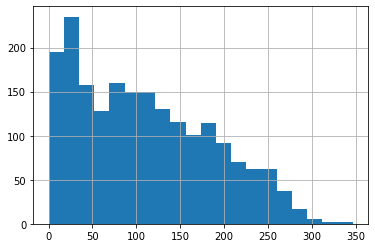

In [14]:
df_MB.RFS_MONTHS.hist(bins=20)

In [15]:
df_MB[df_MB.RFS_MONTHS > 5 * 12].shape

(1340, 35)

## 全体の再発期間のばらつき

In [19]:
year = 5
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS <= 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())

1031
495
309


### 分布ヒストグラム

Text(0.5, 0, 'months')

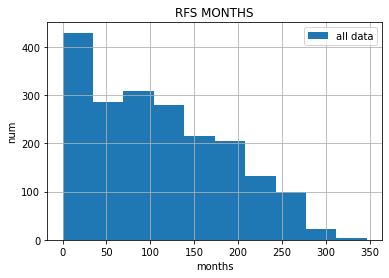

In [20]:
df_MB.RFS_MONTHS.hist(bins=int(math.log2(df_MB.shape[0])), label="all data")
plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

0:Not Reccured -> 初診から最終フォローアップまでの期間なので注意

Text(0.5, 0, 'months')

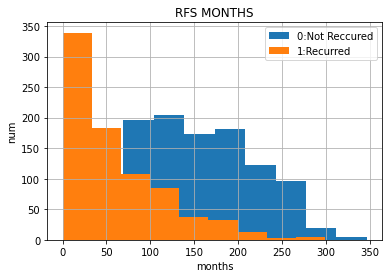

In [21]:
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="0:Not Reccured")
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="1:Recurred")
plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

### KM lineの描画
全体の再発期間の可視化のためにカプランマイヤー曲線を描画

**打ち切り**
右側打ち切り：再発なし患者  
左側打ち切り：なし（今回のデータでは初診からすでに再発している患者がいるか不明なため）  

**注意点**
RFS_MONTHSは再発者であれば初診～再発の期間を示すが、非再発者であれば初診から最終フォローアップまでの期間を示している。  

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

df_tmp = df_MB[["RFS_MONTHS", "RFS_STATUS"]]
df_tmp = df_tmp.replace({"0:Not Recurred": False, "1:Recurred": True})
kmf = KaplanMeierFitter()
kmf.fit(durations=df_tmp.RFS_MONTHS, event_observed=df_tmp.RFS_STATUS)
kmf.plot()

ax.set_xlabel("RFS_MONTHS")
ax.set_ylabel("RECURRENCE PATIENT RATE")
ax.axvline(5 * 12)
ax.axvline(10 * 12)
ax.axvline(15 * 12)
plt.xlim(0, 350)
plt.ylim(0, 1.0)
plt.show()

In [ ]:
def EDA_subgroup_relations(subgroup_name: str, year: int):
    # 統計情報
    print("欠損値数：", df_MB[subgroup_name].isna().sum())
    df_recurred = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
    print("再発者/全患者")
    print(
        df_recurred[subgroup_name].value_counts() / df_MB[subgroup_name].value_counts()
    )
    print("{0}年以内再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS <= 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )
    print("{0}年以後再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS > 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )

    # カプランマイヤー曲線可視化
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()

    for subgroup in df_MB[subgroup_name].unique():
        if type(subgroup) != str:
            continue
        df_subgroup = df_MB[df_MB[subgroup_name] == subgroup][
            ["RFS_MONTHS", "RFS_STATUS"]
        ]
        df_subgroup = df_subgroup.replace({"0:Not Recurred": False, "1:Recurred": True})
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=df_subgroup.RFS_MONTHS,
            event_observed=df_subgroup.RFS_STATUS,
            label=subgroup,
        )
        kmf.plot(ci_show=False)
    ax.set_xlabel("RFS_MONTHS")
    ax.set_ylabel("RECURRENCE PATIENT RATE")
    ax.axvline(5 * 12)
    ax.axvline(10 * 12)
    ax.axvline(15 * 12)
    plt.title(subgroup_name)
    plt.xlim(0, 350)
    plt.ylim(0, 1.0)
    plt.show()
    del df_recurred, df_subgroup

## サブグループの特徴がカテゴリ変数の場合

### CLAUDIN_SUBTYPE

注目したい要因

In [ ]:
EDA_subgroup_relations("CLAUDIN_SUBTYPE", 5)

### その他の要因（注目度低）

In [ ]:
EDA_subgroup_relations("ONCOTREE_CODE", 5)
# ER, HER2
EDA_subgroup_relations("ER_STATUS", 5)
EDA_subgroup_relations("ER_IHC", 5)
EDA_subgroup_relations("HER2_STATUS", 5)
EDA_subgroup_relations("HER2_SNP6", 5)
EDA_subgroup_relations("PR_STATUS", 5)
# その他のサブタイプ
EDA_subgroup_relations("THREEGENE", 5)
EDA_subgroup_relations("HISTOLOGICAL_SUBTYPE", 5)
# 治療法
EDA_subgroup_relations("HORMONE_THERAPY", 5)
EDA_subgroup_relations("RADIO_THERAPY", 5)
EDA_subgroup_relations("BREAST_SURGERY", 5)
EDA_subgroup_relations("CHEMOTHERAPY", 5)

## サブグループの特徴が数値データの場合（カテゴリ化する必要がある）

### NPI
ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index  

In [ ]:
print("欠損値数：", df_MB.NPI.isna().sum())
print("最小値：", df_MB.NPI.min(), " 最大値：", df_MB.NPI.max())
plt.xlim(1, int(df_MB.NPI.max() + 1))
df_MB.NPI.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
year = 5
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)

EDA_subgroup_relations("NPI_CAT", 5)

### 腫瘍サイズ

乳癌のステージの定義：https://oshiete-gan.jp/breast/diagnosis/stages/detail.html

腫瘍サイズ0mm/20mm/50mmで区切るのがよさそう？

In [ ]:
print("欠損値数：", df_MB.TUMOR_SIZE.isna().sum())
print("最小値：", df_MB.TUMOR_SIZE.min(), " 最大値：", df_MB.TUMOR_SIZE.max())
df_MB.TUMOR_SIZE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
year = 5
df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)

EDA_subgroup_relations("TUMOR_CAT", 5)

### リンパ節陽性数

層別化ソース：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

In [ ]:
print("欠損値数：", df_MB.LYMPH_NODES_EXAMINED_POSITIVE.isna().sum())
print(
    "最小値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.min(),
    " 最大値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.max(),
)
df_MB.LYMPH_NODES_EXAMINED_POSITIVE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
print(
    "1/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.25),
    " 1/2分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.5),
    " 3/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.75),
)

In [ ]:
year = 5
df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)

EDA_subgroup_relations("LYMPH_CAT", 5)

### その他の要因（注目度低）

In [ ]:
print("欠損値数：", df_MB.GRADE.isna().sum())
print(
    "最小値：",
    df_MB.GRADE.min(),
    " 最大値：",
    df_MB.GRADE.max(),
)
df_MB.GRADE.hist(bins=int(math.log2(df_MB.shape[0])))

In [ ]:
df_MB["GRADE_CAT"] = pd.cut(
    df_MB.GRADE,
    [0, 1, 2, 3],
    labels=[
        "1",
        "2",
        "3",
    ],
)

EDA_subgroup_relations("GRADE_CAT", 5)

df_MB["TMB_CAT"] = pd.qcut(
    df_MB.TMB_NONSYNONYMOUS, [0, 0.1, 0.9, 1], labels=["c1", "c2", "c3"]
)

EDA_subgroup_relations("TMB_CAT", 5)

# 遺伝子発現量データのEDA

## 各マイクロアレイ手法毎の確認

In [ ]:
dict_gene_expressions.keys()

In [ ]:
for c in itertools.combinations(dict_gene_expressions.keys(), 2):
    print(c)
    list_gene_names = []
    for i in dict_gene_expressions[c[0]]:
        if i not in dict_gene_expressions[c[1]].columns:
            list_gene_names.append(i)
    print(len(list_gene_names))
    list_gene_names = []
    for i in dict_gene_expressions[c[1]]:
        if i not in dict_gene_expressions[c[0]].columns:
            list_gene_names.append(i)
    print(len(list_gene_names))

mrna_agilent_microarrayとmrna_agilent_microarray_zscores_ref_all_samplesの遺伝子は完全に一致しているが、mrna_agilent_microarray_zscores_ref_diploid_samplesはそれら2つとは違うようだ

In [ ]:
df_gene_expressions = dict_gene_expressions[config.SET_NAME_MICROARRAY[1]].copy()

# 結合データのEDA

# 再発者データのEDA

In [ ]:
# 2.1.2-preprocess_cros_RFSのdfを呼び出す
# 臨床データ（層別化対象）と遺伝子データが結合されており、再発者に限定されている

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

## 再発までの期間と遺伝子発現量の相関の確認

In [ ]:
columns_patient = [
    # "RFS_OVER_60MONTHS",
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]
df_recurrenced_gene_expressions = df_recurrenced.drop(columns_patient, axis=1)

In [ ]:
import sweetviz as sv

my_report = sv.analyze(df_recurrenced_gene_expressions, pairwise_analysis="off")

In [ ]:
pd.merge(
    df_recurrenced_gene_expressions, df_MB.RFS_MONTHS, left_index=True, right_index=True
)

## 次元削減

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df_recurrenced_gene_expressions)
print("pca寄与率：", pca.explained_variance_ratio_)

tsne = TSNE(n_components=2, perplexity=2)
tsne_transformed = tsne.fit_transform(df_recurrenced_gene_expressions)

## 分散の確認

分散が小さい→有用な情報は少ないと判断  
zスコア変換済みだとこの情報が失われる（変換過程で分散が均される）ので、生データ（mrna_agilent_microarry）で確認

In [ ]:
dict_gene_expressions["mrna_agilent_microarray"].var().sort_values().tail(60).index

In [ ]:
(dict_gene_expressions["mrna_agilent_microarray"].var() < 0.05).sum()

In [ ]:
# 各特徴の標準偏差
dict_gene_expressions["mrna_agilent_microarray"].std()

In [ ]:
dict_gene_expressions["mrna_agilent_microarray"].describe()